# **Auction Hunters**
## Exploratory Data Analysis Project
## Part 1: Data Aquisition, Cleaning and Verification
#### Joshua Higgins | March~ 2023

## What is *Auction Hunters*?
* Auction hunters is a TV show that aired in the USA from 2010-2015. Hosts Allen and Ton travel and bid for abandoned storage units. Each episode shows where they go, what storage units they bid, how much they win them for, and also shows the most exciting items found in each won unit.
* In each episode, they find buyers for the most profitable items in the storage units they bid on and won.
* The show reports how much each item was sold for, allowing the viewer to keep a tally of their profit for each unit.
* In addition to financial data, we also know where they are and thus can monitor location.
* For more information, check out: https://www.imdb.com/title/tt1742340/

<img src="https://m.media-amazon.com/images/M/MV5BNTc4OTE0MzcxOF5BMl5BanBnXkFtZTcwMjQ0NTM0Ng@@._V1_FMjpg_UX558_.jpg" alt="Hosts Allen and Ton of Auction Hunters">

## Objectives
* Collect series data
* Clean the data
* Verify the data

## Contents

1. Import necessary libraries and set global variables.
2. Scrape episode data from wikipedia.
3. Organise and merge the data into a single dataframe
   * Extract Data
   * Clean Data
   * Verify Data

# 1. Imports and Globals

In [33]:
import requests
from bs4 import BeautifulSoup
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import datetime
import os
import time
import random

In [8]:
URL = "https://en.wikipedia.org/wiki/List_of_Auction_Hunters_episodes"
DATA_DIR = "data"
WEB_DATA_FILENAME = 'auction_hunters_webpage_content.html'
WEBPAGE = f'{DATA_DIR}/{WEB_DATA_FILENAME}'

# 2. Scrape the Data

## 2.1. Download the webpage to avoid multiple requests

In [3]:
# Send an HTTP request to the URL
response = requests.get(URL)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the content with Beautiful Soup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Save the parsed data to a file
    with open(WEBPAGE, 'w', encoding='utf-8') as website_data:
        website_data.write(str(soup))
else:
    print(f">> Status Code: {response.status_code}. Please check settings and try again.")

## 2.2. Load the local copy of the webpage for parsing

In [4]:
with open(WEBPAGE, 'r', encoding='utf-8') as auction_hunters_wiki_website:
    website_read = auction_hunters_wiki_website.read()
    soup = BeautifulSoup(website_read, 'html.parser')

## 2.3. Inspecting the parsed data to find our table of episode information

* Each season's episode information is stored in a table found in the class `wikitable plainrowheaders wikiepisodetable`.
* We can see that there are 5 seasons by calling the length of the find_all of this class.

In [5]:
all_seasons_scrape = soup.find_all(class_=r"wikitable plainrowheaders wikiepisodetable")
number_of_seasons = len(all_seasons_scrape)
print(f">> There are {number_of_seasons} season(s) in the soup! If this is the number you're expecting, continue!")

>> There are 5 season(s) in the soup! If this is the number you're expecting, continue!


## 2.4. Saving the parsed data for each season individually

In [6]:
season_1_data = all_seasons_scrape[0]
season_2_data = all_seasons_scrape[1]
season_3_data = all_seasons_scrape[2]
season_4_data = all_seasons_scrape[3]
season_5_data = all_seasons_scrape[4]
all_seasons_data = [(season_1_data, 1), 
                    (season_2_data, 2), 
                    (season_3_data, 3), 
                    (season_4_data, 4), 
                    (season_5_data, 5)]

## 2.5. Confirm that each season's table contains a full lists of episodes

* In each season's html data, there are 2 classes which contain the data I want to extract.
   * class `vevent` which contains episode, date and location information, and
   * class `expand-child` which contains episode description with cost, sold and profit text.
* There is 1 class `vevent` and `expand-child` for each episode. 
   * This means we can verify that each episode has full information by counting these classes.

In [7]:
def validate_episode_count(season_X):
    """
    This function is designed to be used in a loop. It will take the season data and extract the class counts for vevent and expand_child.
    If this function is successful, you will confirm all the table data is available for each season.
    This function doesn't confirm the total episode counts, so we trust the wikipedia page is complete.
    """
    season_X_data = season_X[0]
    season_X_num = season_X[1]
    
    vevent_count = len(season_X_data.find_all(class_=r'vevent'))
    expand_child_count = len(season_X_data.find_all(class_=r'expand-child'))
    
    print(f">> Season {season_X_num}: Counted {vevent_count} vevent classes and {expand_child_count} expand-child classes.")
    
    if vevent_count == expand_child_count:
        print(f">>>> Class count matches! Season {season_X_num} has {vevent_count} episodes!\n")
    else:
        print(f">> Class count mis-match. Please check your scrape data / class names.\n")


for season in all_seasons_data:
    validate_episode_count(season)

>> Season 1: Counted 8 vevent classes and 8 expand-child classes.
>>>> Class count matches! Season 1 has 8 episodes!

>> Season 2: Counted 27 vevent classes and 27 expand-child classes.
>>>> Class count matches! Season 2 has 27 episodes!

>> Season 3: Counted 26 vevent classes and 26 expand-child classes.
>>>> Class count matches! Season 3 has 26 episodes!

>> Season 4: Counted 26 vevent classes and 26 expand-child classes.
>>>> Class count matches! Season 4 has 26 episodes!

>> Season 5: Counted 20 vevent classes and 20 expand-child classes.
>>>> Class count matches! Season 5 has 20 episodes!



# 3. Extract, Clean and Verify Data

## 3.1. Initial Data Extraction

In [8]:
def get_seasons_episodes_data(season_X_data):
    """
    This function extracts the critical data from the html. Namely:
    
    Data:         [episode number, episode title, location, date]
    Descriptions: [episode description]
    Monetary:     [paid, value, profit]
    
    episode_data = [[Data], [Descriptions], [Monetary]]
                 = [[episode number, episode title, location, date], [episode description], [paid, value, profit]]
    
    
    These 3 lists are captured in a single list for each episode. 
    Thus, the return for each season is a list for each epuside containing 3 lists, which will then need to go through some data cleaning later.
    """
    
    episode_data = []
    episode_descriptions = []
    episode_monetary = []

    # Extract the [episode number, episode title, location, date] data:
    episode_data_tags = season_X_data.find_all(class_=r'vevent')
    for episode_data_tag in episode_data_tags:
        episode_data_list = [data_tag.text for data_tag in episode_data_tag.select("td")]
        episode_data.append(episode_data_list)
        
    # Extract the [episode description] data:
    episode_description_tags = season_X_data.find_all(class_=r'expand-child')
    for episode_description_tag in episode_description_tags:
        episode_description_list = [description.text for description in episode_description_tag.select("p")]
        episode_descriptions.append(episode_description_list)
        
        # In the same class, look for the tag 'dd' containing the monetary [paid, value, profit] data: 
        monetary = [money_values.text for money_values in episode_description_tag.find_all('dd')]
        episode_monetary.append(monetary)

    # Make each episode 1 list of 3 lists (data, description, monetary) and return the entire season's data:
    season_X_full_data_combined = [
        [data, desc, monetary]
        for data, desc, monetary in zip(episode_data, episode_descriptions, episode_monetary)
    ]

    return season_X_full_data_combined

In [9]:
season_1_data_extracted = get_seasons_episodes_data(season_1_data)
season_2_data_extracted = get_seasons_episodes_data(season_2_data)
season_3_data_extracted = get_seasons_episodes_data(season_3_data)
season_4_data_extracted = get_seasons_episodes_data(season_4_data)
season_5_data_extracted = get_seasons_episodes_data(season_5_data)
all_seasons_data_extracted = [(season_1_data_extracted, 1), 
                              (season_2_data_extracted, 2), 
                              (season_3_data_extracted, 3), 
                              (season_4_data_extracted, 4), 
                              (season_5_data_extracted, 5)]

### Validate data extraction (Set as raw text to hide large result output)

## 3.2. Cleaning Data and Converting Season Episode List Data to Dictionary

### 3.2.1. Function: Set Data Field Value - Cleaned or Default

In [76]:
def get_field_value(data, default_value):
    """
    This code will replace repetitive try and except clauses from the original code.
    It will first try to generate a clean data value, but if it can't, it will return a default value.
    This function will be run inside a larger function where the default_value will be passed in.
    
    """
    
    try:
        return data
    except:
        return default_value

### 3.2.2. Function: Generate a Unique Season-Episode Number (as a string)

In [78]:
def generate_unique_season_episode_number(season_num, episode_num):
    """
    This code will generate an episode ID, such as season 1 episode 1 = 101, season 1 episode 12 = 112. 
    It will generate this as a string data type.
    """
    
    s_num = str(season_num)
    ep_num = str(episode_num).zfill(2)
    return s_num + ep_num

### 3.2.3. Function: Generate Episode Data Dictionary with Clean or Default Data

In [13]:
def convert_season_episode_data_to_dict(season_X_data, season_num):
    """
    This function is desidned to be run in a loop and depends on 2 other functions above.
    This function takes season data and season number, then processes each field value, cleans it,
    then stores it in a dictionary. 
    Each episode's data ends up in a dictionary.
    In this way, the entire Auction Hunter show data can be compiled into a large data frame.
    """
    
    field_defaults = {
        'episode_num': 0,
        'episode_name': "----No Episode Name",
        'location': "----No Location",
        'air_date': "----No Air Date",
        'description': "----No Description",
        'paid_$': np.nan,
        'sold_$': np.nan,
        'profit_$': np.nan
    }

    season_X_episode_info_list_of_dicts = []
    for episode in season_X_data:
        ep_num = get_field_value(episode[0][0], field_defaults['episode_num'])
        ep_name = get_field_value(episode[0][1].replace('"', ""), field_defaults['episode_name'])
        ep_loc = get_field_value(episode[0][2], field_defaults['location'])
        
        # Try to extract date information
        try:
            ep_date_initial = episode[0][3]
            ep_date_extract = re.findall(r'\d{4}-\d{2}-\d{2}', ep_date_initial)
            ep_date = datetime.datetime.strptime(ep_date_extract[0], '%Y-%m-%d').date()
        except:
            ep_date = field_defaults['air_date']
        
        # Check if the description list is empty
        if episode[1]:
            ep_desc = get_field_value(episode[1][0].replace("\n", "").replace("  ", " "), field_defaults['description'])
        else:
            ep_desc = field_defaults['description']
            
        ep_paid = get_field_value(episode[2][0].replace(",", "").replace("$", ""), field_defaults['paid_$'])
        ep_sold = get_field_value(episode[2][1].replace(",", "").replace("$", ""), field_defaults['sold_$'])
        ep_profit = get_field_value(episode[2][2].replace(",", "").replace("$", ""), field_defaults['profit_$'])
        
        unique_ep_ID = generate_unique_season_episode_number(season_num, ep_num)
            
        ep_dict = {
            'season_num': season_num,
            'episode_num': ep_num,
            'unique_ep_ID': unique_ep_ID,
            'episode_name': ep_name, 
            'location': ep_loc, 
            'air_date': ep_date, 
            'description': ep_desc, 
            'paid_$': ep_paid, 
            'sold_$': ep_sold, 
            'profit_$': ep_profit
        }

        season_X_episode_info_list_of_dicts.append(ep_dict)

    return season_X_episode_info_list_of_dicts

### 3.2.4. Generate each season's cleaned episode information as a dictionary.

In [14]:
season_1_data_dict = convert_season_episode_data_to_dict(all_seasons_data_extracted[0][0], all_seasons_data_extracted[0][1])
season_2_data_dict = convert_season_episode_data_to_dict(all_seasons_data_extracted[1][0], all_seasons_data_extracted[1][1])
season_3_data_dict = convert_season_episode_data_to_dict(all_seasons_data_extracted[2][0], all_seasons_data_extracted[2][1])
season_4_data_dict = convert_season_episode_data_to_dict(all_seasons_data_extracted[3][0], all_seasons_data_extracted[3][1])
season_5_data_dict = convert_season_episode_data_to_dict(all_seasons_data_extracted[4][0], all_seasons_data_extracted[4][1])
all_seasons_data_dict = [(season_1_data_dict, 1), 
                         (season_2_data_dict, 2), 
                         (season_3_data_dict, 3), 
                         (season_4_data_dict, 4), 
                         (season_5_data_dict, 5)]

## 3.3. Exporting Dictionaries to CSV by Season

In [16]:
def generate_all_season_dicts_to_csv_and_filenames(all_seasons_dicts):
    """
    This function will take the all_seasons_data_dict list containing cleaned season data dictionaries and season number tuples,
      and converting each season into its own csv file AND a csv file of the ENTIRE series data.
    Returns a list of filenames generated for the CSV files.
    
    """
    generated_filenames = []

    for season_dict in all_seasons_dicts:
        season_data = season_dict[0]
        season_df = pd.DataFrame.from_records(season_data)

        season_num = season_dict[1]
        filename = f"{DATA_DIR}/auction_hunters_season_{season_num}_data.csv"

        # Check if the csv file data already exists:
        if os.path.isfile(filename):
            print(f">> '{filename}' already exists. Skipping save operation. Handle existing data, then try again.")
        else:
            season_df.to_csv(filename, index=False)
            generated_filenames.append(filename)
    
    sorted_generated_filenames = sorted(generated_filenames)

    return sorted_generated_filenames

In [17]:
csv_filenames = generate_all_season_dicts_to_csv_and_filenames(all_seasons_data_dict)

## 3.4. Cleaning the data

### 3.4.1. Generate a list of csv files `(update: incorporated into csv generation function above)`

In [18]:
print(csv_filenames)

['data/auction_hunters_season_1_data.csv', 'data/auction_hunters_season_2_data.csv', 'data/auction_hunters_season_3_data.csv', 'data/auction_hunters_season_4_data.csv', 'data/auction_hunters_season_5_data.csv']


### 3.4.2. Function to load the CSVs into a single dataframe

In [19]:
def load_all_csvs_to_df(list_of_CSVs):
    """
    This function will take a list of csv files, convert them into dataframes, then return a joined single dataframe composed of the input data.
    """
    
    # Specifying the data types so that they are consisent for each loaded dataframe.
    column_data_types_cleaning = {
        'season_num': 'int8',
        'episode_num': 'int8',
        'unique_ep_ID': 'int16',
        'episode_name': 'object',
        'location': 'object',
        'air_date': 'object',
        'description': 'object',   
        'paid_$': 'object',
        'sold_$': 'object',
        'profit_$': 'object' 
    }			
    
    # Create a list of dataframe objects
    df_list = []   
    for csv_file in list_of_CSVs:
        df = pd.read_csv(csv_file, dtype=column_data_types_cleaning)
        df_list.append(df)
        
    # Concatenate the dataframes into a single dataframe object.
    # Also, reset the index to avoid concatenation restarting the index at each join.
    combined_df = pd.concat(df_list, axis=0)
    combined_df = combined_df.reset_index(drop=True)
    
    return combined_df

### 3.4.3. Create the full dataframe

In [20]:
# Set Pandas display options so that we can see the entire dataframe.
pd.set_option('display.max_rows', None)     # Shows all rows
pd.set_option('display.max_columns', None)  # Shows all columns
pd.set_option('display.width', None)        # Adjusts the display width

In [20]:
df = load_all_csvs_to_df(csv_filenames)
df

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
0,1,1,101,The Wild West,"San Bernardino, California",2010-11-09,Ton and Allen head to auctions in the desert t...,376,1190,814
1,1,2,102,The Big Score,"Downtown Los Angeles, California",2010-11-09,Ton and Allen bid on units in downtown LA and ...,2025,5850,3825
2,1,3,103,Ton's Got a Gun,"Mission Hills, California",2010-11-16,Allen encounters some old rivals in the Valley...,1900,9450,7550
3,1,4,104,Strat'ed for Cash,"West Adams, Los Angeles",2010-11-23,Allen and Ton venture out to storage auctions ...,975,6200,5225
4,1,5,105,The Real Thing,"Oxnard, California",2010-11-30,"In a small beachtown’s storage unit auction, T...",2450,9400,6950
5,1,6,106,Weapons of Past Destruction,Sunset Boulevard,2010-12-07,Ton and Allen travel to Hollywood and uncover ...,295,1635,1340
6,1,7,107,Gangster Whiskey,"Moreno Valley, California",2010-12-14,"A rare baseball card, a classic jukebox and an...",525,2800,2275
7,1,8,108,Home on the Gun Range,"Corona, California",2010-12-21,A single unit auction yields a 1940s Kissomete...,875,3400,2425
8,2,1,201,Miami Heat,Miami,2011-04-05,"A 1970s NASA countdown clock, a 1960s Delta re...",2800,10640,7840
9,2,2,202,Quadzilla Attacks!,"Playa Vista, Los Angeles",2011-04-05,"An 1880s Palm-Squeezer pistol, a Western Elect...",1250,4990,3740


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   season_num    107 non-null    int8  
 1   episode_num   107 non-null    int8  
 2   unique_ep_ID  107 non-null    int16 
 3   episode_name  107 non-null    object
 4   location      106 non-null    object
 5   air_date      107 non-null    object
 6   description   107 non-null    object
 7   paid_$        107 non-null    object
 8   sold_$        107 non-null    object
 9   profit_$      107 non-null    object
dtypes: int16(1), int8(2), object(7)
memory usage: 6.4+ KB


`The dataframe appears structured. There is just 1 Null, however default values could be masking them. Datatypes are OK as we are still cleaning.
107 rows of data`

# 3.5. There is some basic cleaning to do on the base dataset

1. Remove the text from the Paid, Sold and Profit fields and cast datatypes.
3. Cast air_date datatype correctly.
2. Ensure all fields are filled. e.g:
   * episode 514: Location
   * episode 401: Description

In [22]:
df_cleaning = df.copy()

### 3.5.1. Remove text and set datatype for monetary columns

In [23]:
# Here, we will strip the sentences and keep only the first element which contains the monetary value we want to keep.
df_cleaning['paid_$'] = df['paid_$'].str.strip()
df_cleaning['paid_$'] = df['paid_$'].str.split().str[0].astype("int32")

df_cleaning['sold_$'] = df['sold_$'].str.strip()
df_cleaning['sold_$'] = df['sold_$'].str.split().str[0].astype("int32")

df_cleaning['profit_$'] = df['profit_$'].str.strip()
df_cleaning['profit_$'] = df['profit_$'].str.split().str[0].astype("int32")

In [24]:
# Rows 16, 19, 31 have text in different monetary columns. We can verify there quickly.
df_cleaning[16:33]

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
16,2,9,209,Animal Instincts,"Orange County, California",2011-05-24,An 1897 Winchester pump-action shotgun and big...,2700,9600,6840
17,2,10,210,Everything's Bigger in Texas,North Texas,2011-05-31,Ton and Allen head 225 miles north of Dallas t...,2975,20570,17595
18,2,11,211,The Smoking Ton,"Worcester, Massachusetts",2011-07-17,"The guys find an 1890 humidor, a gun barrel fo...",1875,10450,8575
19,2,12,212,Top Gun Ton,"Ontario, California",2011-07-19,Ton and Allen buy two units. One contains a co...,1750,10825,8475
20,2,13,213,Beantown Bidders,Boston,2011-07-19,"A 1940s–50s Schwinn tandem bicycle, assorted b...",975,7300,6325
21,2,14,214,Diesel Digs,"Los Angeles, California",2011-08-02,"In an industrial area of Los Angeles, the pair...",1350,8575,7225
22,2,15,215,The Dallas Mavericks,Dallas,2011-08-09,"The guys go to Dallas, where they find a handc...",2150,12125,9975
23,2,16,216,Knuckle Dust,"Hollywood, California",2011-08-16,"The guys sell a 19th-century French ""knuckle d...",1050,13750,12700
24,2,17,217,Half Pipe Dreams,"Long Beach, California",2011-08-23,The guys find a 1970s Z-Flex Jimmy Plumer Pool...,1400,5300,3900
25,2,18,218,Viva la Vegas,"Henderson, Nevada",2011-08-30,The guys head to Las Vegas to acquire a Zig Za...,320,5070,4750


### 3.5.2. Setting Datetime column datatype

In [25]:
df_cleaning['air_date'] = pd.to_datetime(df['air_date'], format='%Y-%m-%d')

In [26]:
df_cleaning[16:20]

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
16,2,9,209,Animal Instincts,"Orange County, California",2011-05-24,An 1897 Winchester pump-action shotgun and big...,2700,9600,6840
17,2,10,210,Everything's Bigger in Texas,North Texas,2011-05-31,Ton and Allen head 225 miles north of Dallas t...,2975,20570,17595
18,2,11,211,The Smoking Ton,"Worcester, Massachusetts",2011-07-17,"The guys find an 1890 humidor, a gun barrel fo...",1875,10450,8575
19,2,12,212,Top Gun Ton,"Ontario, California",2011-07-19,Ton and Allen buy two units. One contains a co...,1750,10825,8475


In [27]:
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   season_num    107 non-null    int8          
 1   episode_num   107 non-null    int8          
 2   unique_ep_ID  107 non-null    int16         
 3   episode_name  107 non-null    object        
 4   location      106 non-null    object        
 5   air_date      107 non-null    datetime64[ns]
 6   description   107 non-null    object        
 7   paid_$        107 non-null    int32         
 8   sold_$        107 non-null    int32         
 9   profit_$      107 non-null    int32         
dtypes: datetime64[ns](1), int16(1), int32(3), int8(2), object(3)
memory usage: 5.1+ KB


### 3.5.3. Setting Missing Values

In [28]:
# Let's set a description for episode 401
# Source: "https://tv.apple.com/au/episode/once-a-pawn-a-time/umc.cmc.u7kqqkzw16hliw0oa6y8jsd9"
episode_401_description = "Allen and Ton have opened a pawn shop in Los Angeles, but with expenses piling up, even an antique ammo collection and some vintage football helmets may not be enough to keep the boys in business."
episode_401_index = df[df['unique_ep_ID'] == 401].index[0]
df_cleaning.loc[episode_401_index, 'description'] = episode_401_description

In [29]:
df_cleaning[60:63]

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
60,3,26,326,Gold ‘N’ Gloves,"Hermosa Beach, California",2012-09-26,The Auction Hunters team goes toe-to-toe with ...,950,5518,4568
61,4,1,401,Once a Pawn a Time,"Covina, California",2013-01-30,Allen and Ton have opened a pawn shop in Los A...,2000,19000,17000
62,4,2,402,Win Lose Or Joust,"North Hills, Los Angeles",2013-01-30,Ton and Allen race back from an auction to pur...,1050,5500,4450


In [30]:
# Let's set a location for episode 514
### Absent any specific data, "California" is the best guess.
episode_514_location = "California"
episode_514_index = df[df['unique_ep_ID'] == 514].index[0]
df_cleaning.loc[episode_514_index, 'location'] = episode_514_location

In [31]:
df_cleaning[99:102]

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
99,5,13,513,Wreck-Shaw,"Santa Clarita, California",2015-04-18,A weekend auction sees the guys go up against ...,3500,5400,1900
100,5,14,514,Carnies & Armories,California,2015-04-18,A tough group of bidders team up to take down ...,1750,10700,8950
101,5,15,515,The Unsinkable Ton,"Stanton, California",2015-04-25,The guys try to authenticate props from the mo...,2700,5800,3100


In [105]:
df_cleaning.sample(20)

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$
89,5,3,503,"Hook, Line and Printer","Norwalk, California",2014-10-25,A last-minute auction proves challenging as th...,1451,6150,4699
87,5,1,501,Space Cowboys,"Santa Clarita, California",2014-10-11,"In the Season 5 premiere, Ton and Allen start ...",3300,22200,18900
38,3,4,304,Hidden Hot Wheels,"Covina, California",2012-04-04,The guys head to Covina and discover a 1969 Ch...,1350,14182,12832
34,2,27,227,Early Bird Special,"Stanton, California",2011-11-29,The guys head to an early-morning auction in S...,800,8430,7630
74,4,14,414,Separation Anxiety,"El Segundo, California",2014-01-18,Allen takes out Elle his new partner to her fi...,1800,4000,2200
31,2,24,224,Great American Cashtime,"San Diego, California",2011-11-08,The guys head to San Diego and discover a 1950...,2200,5840,3640
19,2,12,212,Top Gun Ton,"Ontario, California",2011-07-19,Ton and Allen buy two units. One contains a co...,1750,10825,8475
48,3,14,314,Voodoo Moola,"Baton Rouge, Louisiana",2012-06-06,"The guys head to Baton Rouge, LA and discover ...",470,8980,8510
69,4,9,409,Machine Gun Ton,"Pomona, California",2013-03-23,Ton and Allen battle a pair of vicious female ...,1600,9300,7700
76,4,16,416,You Got Served,"West Adams, Los Angeles",2014-02-01,Ton and Allen head to auction while the shop e...,1515,3000,1485


In [33]:
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   season_num    107 non-null    int8          
 1   episode_num   107 non-null    int8          
 2   unique_ep_ID  107 non-null    int16         
 3   episode_name  107 non-null    object        
 4   location      107 non-null    object        
 5   air_date      107 non-null    datetime64[ns]
 6   description   107 non-null    object        
 7   paid_$        107 non-null    int32         
 8   sold_$        107 non-null    int32         
 9   profit_$      107 non-null    int32         
dtypes: datetime64[ns](1), int16(1), int32(3), int8(2), object(3)
memory usage: 5.1+ KB


## 3.6. Verify Profit and Dates

* Before starting, we will create a new dataframe. 
* I want to confirm whether or not the profit column is correct.
   * The equation: Profit = Sold - Paid must hold true for each row. Let's test it.
* Then, I want to confirm that the air_date is sequential with the episode number.

In [34]:
df_cleaned = df_cleaning.copy()

### 3.6.1. Confirm Scraped Profit vs. Calculated Profit

In [35]:
# Generate a new column showing the calculated profit calculated from paid and sold columns.
df_cleaned['calculated_profit_$'] = (df_cleaning['sold_$'] - df_cleaning['paid_$']).astype('int32')

In [37]:
df_cleaned[df_cleaned['profit_$'] != df_cleaned['calculated_profit_$']]

,season_num,episode_num,unique_ep_ID,episode_name,location,air_date,description,paid_$,sold_$,profit_$,calculated_profit_$
7,1,8,108,Home on the Gun Range,"Corona, California",2010-12-21,A single unit auction yields a 1940s Kissomete...,875,3400,2425,2525
16,2,9,209,Animal Instincts,"Orange County, California",2011-05-24,An 1897 Winchester pump-action shotgun and big...,2700,9600,6840,6900
19,2,12,212,Top Gun Ton,"Ontario, California",2011-07-19,Ton and Allen buy two units. One contains a co...,1750,10825,8475,9075
83,4,23,423,"Cashville, Tennessee","Nashville, Tennessee",2014-03-29,"Ton and Allen hit the road for Nashville, wher...",12800,13375,-2425,575


**We can see there are 4 rows where the calculated profit is different from the scraped profit.**

**Episode 108**
   * It appears to be a simple miscalcluation. There may have been some purchase/travel fees they didn't include in the final profit.
   * Scraped value 2425 is *probably* OK (error is small ~4%).
   
**Episode 209**
   * The episode hinted that "just over 2700" was paid for the storage units, so the difference is likely due to this.
   * Scraped value 6840 is OK as the show hints over 2700 was paid, indicating a decreased profit.
   
**Episode 212**
   * The sold value of 10825 includes the value of the plane that Ton crashed. So the 600 difference is from that lost money.
   * Scraped value 8475 is OK.
   
**Episode 423**
   * This episode included the cost of travel in the paid value, but it is not shown in the table. Paid 12800 + travel 3000 = 15800. Sold 13375.
   * Scraped value -2425 is OK.
   
**✔️ Based on this, I think the original profit column is OK!**

### 2.6.2. Confirm air_date is in sequence with unique_ep_ID

#### 2.6.2.1. Interactive Graph

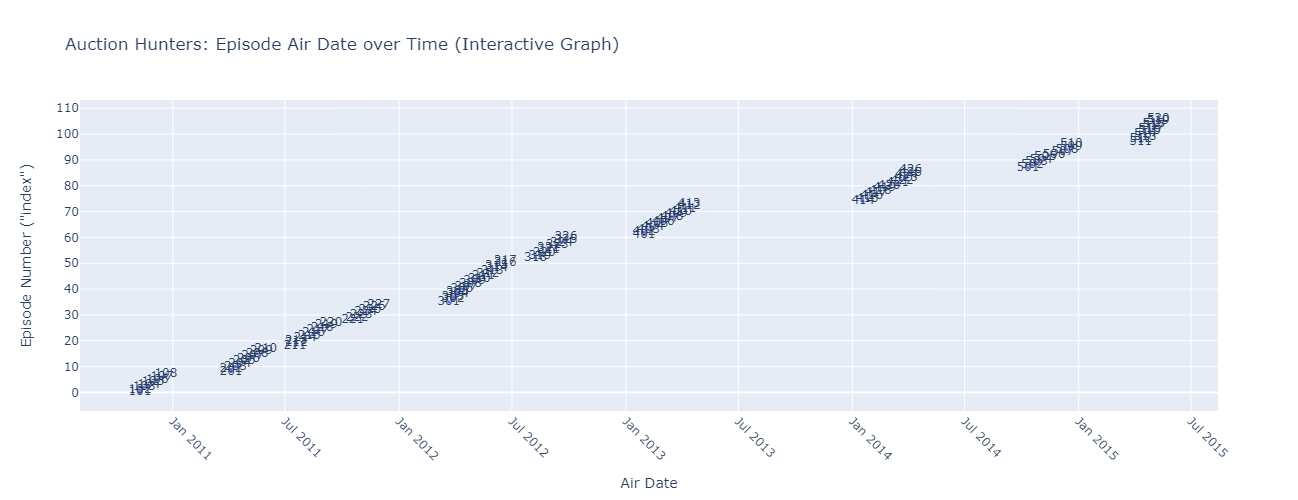

In [94]:
fig = px.scatter(df_cleaned, x='air_date', y=df_cleaned.index, text='unique_ep_ID', title='Auction Hunters: Episode Air Date over Time (Interactive Graph)')
fig.update_traces(mode='markers+text', marker=dict(size=3))
fig.update_layout(
    xaxis_title='Air Date',
    yaxis_title='Episode Number ("index")',
    xaxis=dict(tickangle=45, nticks=20),             # Adjust nticks to change grid frequency
    yaxis=dict(nticks=20),                           # Adjust nticks to change grid frequency
    hovermode='x unified',
    hoverlabel=dict(bgcolor="white", font_size=12),
    width=1000,                                      # Adjust the figure width
    height=500,                                      # Adjust the figure height
)

fig.show()

#### 2.6.2.2. Static Graph

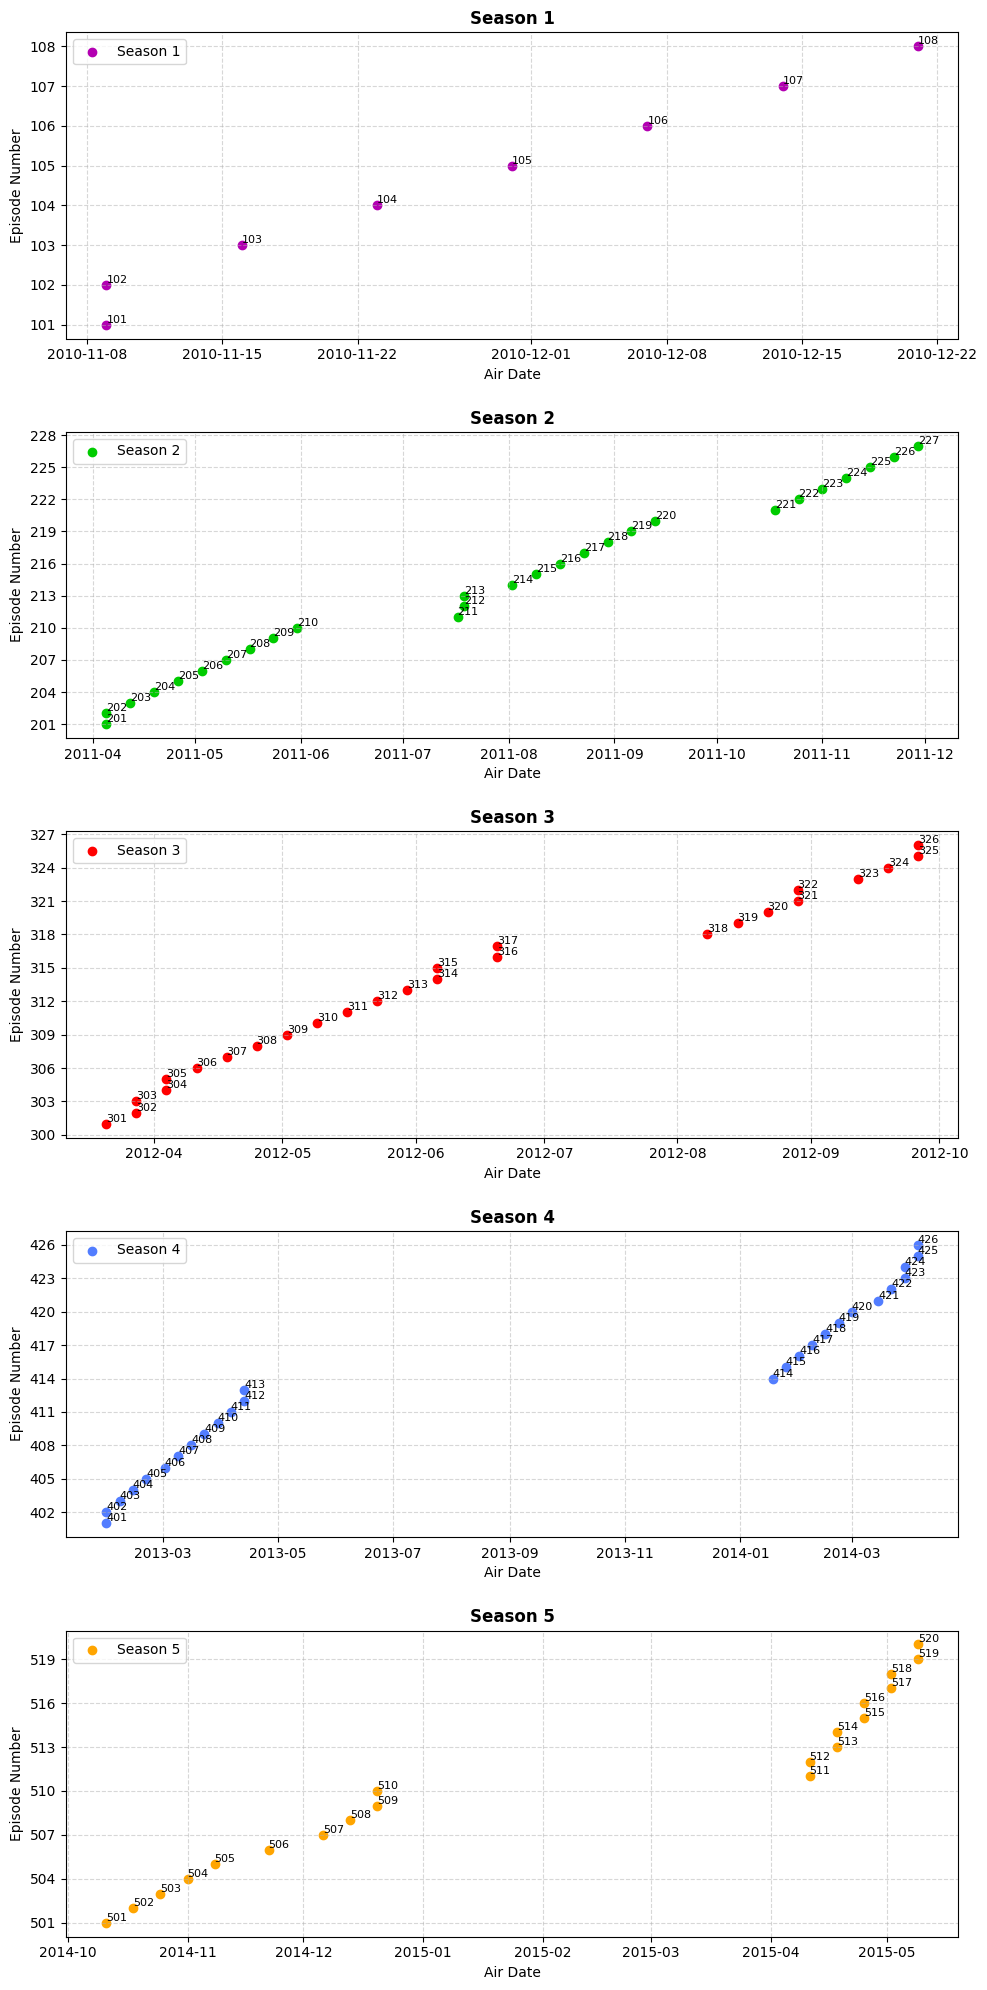

In [92]:
# Season numbers
season_numbers = [1, 2, 3, 4, 5]

# Define colors for each season (in order)
colors = ['#B300B2', '#00CC00', '#FF0000', '#527DFF', '#FFA500']
          # purple, light green, red, light blue, orange

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 20))  # Increased vertical spacing

# Loop through each season's data
for i, season_num in enumerate(season_numbers):
    # Select data for the current season
    season_data = df_cleaned[df_cleaned['season_num'] == season_num]
    
    # Extract unique_ep_ID and air_date
    unique_ep_ID = season_data['unique_ep_ID']
    air_date = season_data['air_date']
    
    # Plot the data with the color in order of appearance
    axs[i].scatter(air_date, unique_ep_ID, c=colors[i], label=f'Season {season_num}')
    
    # Annotate the points with unique_ep_ID
    for j, ep_id in enumerate(unique_ep_ID):
        axs[i].annotate(ep_id, (air_date.iloc[j], ep_id), fontsize=8, verticalalignment='bottom')
    
    # Set labels and title for the subplot
    axs[i].set_xlabel('Air Date')
    axs[i].set_ylabel('Episode Number')
    axs[i].set_title(f'Season {season_num}', fontweight='bold')  # Bold title
    
    # Add grid lines with minor gridlines for the X-axis
    axs[i].grid(True, linestyle='--', alpha=0.5)  # Dashed lines with lower opacity
    
    # Format y-axis labels to show only whole numbers (sometimes it's generated with decimal points e.g. 502.5)
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Add season and color legend
    axs[i].legend()

# Adjust subplot spacing
plt.tight_layout(h_pad=2.0)

# Show the plots
plt.show()

#### 2.6.2.3. Chronology Check using Logic

In [116]:
def chronology_check(dataframe, date_column):
    """
    This function takes a dataframe input with a datetime column and determines whether the date from index 0 to last is in chronological order.
    This function will simply count the number of times where the n+1 row date is earlier than the n row date.
    """
    
    df = dataframe
    date_col = date_column
    num_rows = len(df)
  
    # Here we define the index range and the dates we will compare.
    count = 0        
    for i in range(num_rows - 1):
        date1 = df.loc[i, date_col]
        date2 = df.loc[i + 1, date_col]

        # If the date of row n+1 is before the date of row n, mark it as NOT chronological, thus increase the count 1 point.
        # Note that some episodes air on the same date as double episodes, so the = condition is not set to trigger false positives.
        if date2 < date1:
            count += 1
    
    # Report findings. If count is greater than zero, then chronology is bad i.e. episodes are listed in the wrong order.
    if count > 0:
        print(f">> ❌ Dates ARE NOT chronological. Found {count} discrepancies.")
    # Else, the dates and episode numberings are chronological, thus there is no issue with the order of episodes.
    else:
        print(">> ✔️ Dates ARE chronological!")


In [117]:
chronology_check(df_cleaned, 'air_date')

>> ✔️ Dates ARE chronological!


# 3.7. Save Verified Cleaned Dataframe to CSV

In [ ]:
# remove the calculated_profit column as it will not supercede the original scraped data.
df_final = df_cleaned.drop(columns=['calculated_profit_$'])

In [121]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   season_num    107 non-null    int8          
 1   episode_num   107 non-null    int8          
 2   unique_ep_ID  107 non-null    int16         
 3   episode_name  107 non-null    object        
 4   location      107 non-null    object        
 5   air_date      107 non-null    datetime64[ns]
 6   description   107 non-null    object        
 7   paid_$        107 non-null    int32         
 8   sold_$        107 non-null    int32         
 9   profit_$      107 non-null    int32         
dtypes: datetime64[ns](1), int16(1), int32(3), int8(2), object(3)
memory usage: 5.1+ KB


In [120]:
# Specify the path and filename of the cleaned data csv:
cleaned_data_filename = f"{DATA_DIR}/auction_hunters_cleaned_data.csv"

# Check if the csv file data already exists:
if os.path.isfile(cleaned_data_filename):
    print(f">> '{cleaned_data_filename}' already exists. Skipping save operation. Handle existing data, then try again.")
else:
    df_final.to_csv(cleaned_data_filename, index=False)

# 3.8. 🎉 Data Cleaning Complete 🎉

# 3.9. 🛑 Wait!!! Can I get Episode Ratings Data, too? 🛑

## 3.9.1. Prepare scraping for new URL

In [25]:
ratings_base_url = f"https://www.imdb.com/title/tt1742340/episodes/?season=" # Need to add 1,2,3,4,5 to the end to load each page.
sn_num_list = [1, 2, 3, 4, 5]
imdb_headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"}

In [47]:
def get_ratings_webpage(base_url, seasons_num_list, headers):
    """
    This function will download each webpage containing ratings data from the base URL and season number passed through that the user passes through.
    It will name each page with a unique filename, save it, then return a list of said filenames.
    
    """
    
    save_names = []
    # Send an HTTP request to the URL for each season number
    for season_num in seasons_num_list:
        url = f"{base_url}{season_num}"
        print(f">> Processing Season {season_num}....")
        
        # Avoid getting banned for scraping! Sleep for a time between 8 and 15 seconds:
        time.sleep(random.randint(8, 15))
        
        response = requests.get(url, headers=headers)
        filename = f"imdb_auction_hunters_s{season_num}.html"
        full_name = f"{DATA_DIR}/{filename}"
        
        # Check if the  data already exists:
        if os.path.isfile(full_name):
            print(f"🛑'{full_name}' already exists. Skipping save operation. Handle existing data, then try again.")
        else:      
            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                # Parse the content with Beautiful Soup
                soup = BeautifulSoup(response.text, 'html.parser')
                # Save the parsed data to a file
                with open(full_name, 'w', encoding='utf-8') as website_data:
                    website_data.write(str(soup))
                    print(f"✅'{full_name}' saved successfully!")
            else:
                print(f">> Status Code: {response.status_code}. Please check settings and try again.")
            
        save_names.append(full_name)
        
    return save_names

In [45]:
imdb_webpages = get_ratings_webpage(ratings_base_url, sn_num_list, imdb_headers)

>> Processing Season 1....
✅'data/imdb_auction_hunters_s1.html' saved successfully!
>> Processing Season 2....
✅'data/imdb_auction_hunters_s2.html' saved successfully!
>> Processing Season 3....
✅'data/imdb_auction_hunters_s3.html' saved successfully!
>> Processing Season 4....
✅'data/imdb_auction_hunters_s4.html' saved successfully!
>> Processing Season 5....
✅'data/imdb_auction_hunters_s5.html' saved successfully!


In [46]:
print("You have these files:")
pprint.pprint(imdb_webpages)

You have these files:
['data/imdb_auction_hunters_s1.html',
 'data/imdb_auction_hunters_s2.html',
 'data/imdb_auction_hunters_s3.html',
 'data/imdb_auction_hunters_s4.html',
 'data/imdb_auction_hunters_s5.html']


## 3.9.2. Parse each page and extract relevant data

### 3.9.2.1. Check the completeness of the scraped data

In [190]:
def confirm_lengths_and_get_webpage_data(webpage_data):
    """
    This function is designed to run in a loop.
    This function will determine if within the webpage data, the lists that extract the different parts
     of the episode data are the same length. If they are, it indicates a complete data set. 
    If the lists are not the same length, it means some episodes have incomplete data.
    Returns a list of each_season_soup_data.
    """
    
    # First, let's extract the season number
    season_num_pattern = r'\d+'  # Match one or more digits
    season_num = re.search(season_num_pattern, webpage_data)
    season_num = season_num.group()
    print(f"🏃‍ Parsing Season {season_num}:")
    
    this_seasons_soup_data = []

    with open(webpage_data, 'r', encoding='utf-8') as data:
        website_read = data.read()
        soup = BeautifulSoup(website_read, 'html.parser')

        each_episode_s_num_ep = soup.find_all(class_ = "sc-1318654d-7 fACRye")  
        each_episode_air_date = soup.find_all(class_ = "sc-1318654d-10 jEHgCG")   
        each_episode_description = soup.find_all(class_ = "ipc-html-content-inner-div")  
        each_episode_rating = soup.find_all(class_ = "ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating")

        this_seasons_soup_data.append(each_episode_s_num_ep)
        this_seasons_soup_data.append(each_episode_air_date)
        this_seasons_soup_data.append(each_episode_description)
        this_seasons_soup_data.append(each_episode_rating)
        
        a = len(each_episode_s_num_ep)
        b = len(each_episode_air_date)
        c = len(each_episode_description)
        d = len(each_episode_rating)

        print(f">> s_num_ep: {a}\n>> air_date: {b}\n>> desc: {c}\n>> rating: {d}")
        if a == b and a == c and a == d and b == c and b == d and c == d:
            print("✅ All data lists are the same length!\n")
        else:
            print("❌ One or more lists is unequal in length to the others. Some data is missing 😥\n")
            
    return (this_seasons_soup_data, season_num)

In [191]:
all_season_soups = []

for webpage in imdb_webpages:
    all_season_soups.append(confirm_lengths_and_get_webpage_data(webpage))

🏃‍ Parsing Season 1:
>> s_num_ep: 9
>> air_date: 9
>> desc: 9
>> rating: 9
✅ All data lists are the same length!

🏃‍ Parsing Season 2:
>> s_num_ep: 27
>> air_date: 27
>> desc: 27
>> rating: 26
❌ One or more lists is unequal in length to the others. Some data is missing 😥

🏃‍ Parsing Season 3:
>> s_num_ep: 30
>> air_date: 29
>> desc: 28
>> rating: 28
❌ One or more lists is unequal in length to the others. Some data is missing 😥

🏃‍ Parsing Season 4:
>> s_num_ep: 19
>> air_date: 19
>> desc: 17
>> rating: 15
❌ One or more lists is unequal in length to the others. Some data is missing 😥

🏃‍ Parsing Season 5:
>> s_num_ep: 20
>> air_date: 19
>> desc: 20
>> rating: 2
❌ One or more lists is unequal in length to the others. Some data is missing 😥



In [193]:
pprint.pprint(all_season_soups)

[([[<h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1770898/?ref_=ttep_ep1">S1.E1 ∙ The Wild West</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1770897/?ref_=ttep_ep2">S1.E2 ∙ The Big Score</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1776386/?ref_=ttep_ep3">S1.E3 ∙ Ton's Got a Gun</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1779941/?ref_=ttep_ep4">S1.E4 ∙ Strat'ed for Cash</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1781093/?ref_=ttep_ep5">S1.E5 ∙ The Real Thing</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1807105/?ref_=ttep_ep6">S1.E6 ∙ Weapons of Past Destruction</a></h4>,
    <h4 class="sc-1318654d-7 fACRye"><a class="sc-1318654d-8 bglHll" href="/title/tt1807103/?ref_=ttep_ep7">S1.E7 ∙ Gangster Whiskey</a></h

**OK, so it seems that some data verification will be needed. Never fear, we already have it** 😁

### 3.9.2.2. Parse and extract the data we do have

In [195]:
def extract_imdb_data(webpage_soup, pprint_data=True):
    """
    This function will be used in a loop.
    This function will take in a webpage and extract the data for each episode.
    Returns a XXXXXXXXXXXXXX of each season's data.
    """
    # First, extract the webpage data (season data) and season number from the input argument:
    ## Remember - soup is a list [[ep1,ep2,ep3..], [date1,date2,date3..], [desc1,desc2,desc3..], [rate1,rate2,rate3..]]
    soup = webpage_soup[0]      
    season_num = int(webpage_soup[1])
    
    # Now, we want to organise the data into episodes, not categories. So we need to split it and zip back together.
    ### Can this and the next code be simplified?
    combine_episode_data = list(zip(
        soup[0],  # epnum info
        soup[1],  # air date info
        soup[2],  # ep description
        soup[3])) # rating info

    list_of_ep_data = [list(item) for item in combine_episode_data]
    if pprint_data == True:
        pprint.pprint(list_of_ep_data)
         
    # Now, we are going to extract the data from the episode organised soups. We will specify default values in case the extraction fails.
    field_defaults = {
        'episode_num': 0,
        'episode_name': "----No Episode Name",
        'air_date': "----No Air Date",
        'description': "----No Description",
        'rating' : np.nan,
        'num_rates' : np.nan
    }

    episode_data = []

    for episode in list_of_ep_data:
        soup = BeautifulSoup(' '.join(str(epdata) for epdata in episode), 'html.parser')

        # Extract relevant information
        
        # get_field_value(A, field_defaults[''])
        
        
        ep_num_strip = f"S{season_num}.E"
        episode_number = soup.find('h4', class_='sc-1318654d-7 fACRye').text.split(" ∙ ")[0].strip(ep_num_strip)
        episode_title = soup.find('h4', class_='sc-1318654d-7 fACRye').text.split(" ∙ ")[1]
        air_date = soup.find('span', class_='sc-1318654d-10 jEHgCG').text
        description = soup.find('div', class_='ipc-html-content-inner-div').text

        rating = soup.find('span', class_='ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating').text.split()[0].strip("/10")
        rating = float(rating)

        num_ratings = soup.find('span', class_='ipc-rating-star--voteCount').text
        num_ratings_pattern = r'\d+'  # Match one or more digits
        num_ratings_int = re.search(num_ratings_pattern, num_ratings)
        num_ratings_int = num_ratings_int.group()

        # Print the extracted data
        print("Episode Number:", episode_number)
        print("Episode Title:", episode_title)
        print("Air Date:", air_date)
        print("Description:", description)
        print("Rating:", rating)
        print("Number of Ratings:", num_ratings_int)
        print("")

        
extract_imdb_data(all_season_soups[0], pprint_data=False)

Episode Number: 
Episode Title: The Wild West
Air Date: Tue, Nov 9, 2010
Description: Ton and Allen head to auctions in the desert town of San Bernardino. Ton scores a deadly 1800s British Pepperbox handgun and tests it at the gun range. Allen wins a unit for a $1 and finds a fully functional pre-WWI train set.
Rating: 7.8
Number of Ratings: 34

Episode Number: 2
Episode Title: The Big Score
Air Date: Tue, Nov 9, 2010
Description: The business of storage unit auctions has emerged as a thriving trade for many, including Allen Haff & Ton Jones. Ton and Allen bid on units in downtown LA and uncover a '70s German H&K P7 pistol and a rare copper cash register.
Rating: 6.5
Number of Ratings: 26

Episode Number: 3
Episode Title: Ton's Got a Gun
Air Date: Tue, Nov 16, 2010
Description: The guys enter a high-stakes bidding war with Allen's old rivals. Ton and Allen uncover a depression-era "Art Case" slot machine, a custom mini-bike and a Wild West 1880s Colt Peacemaker, but can they turn a pro